# Human hematpoiesis: preprocessing

Source: https://github.com/aristoteleo/dynamo-release/discussions/411

In [1]:
%load_ext nb_black

import dynamo as dyn
import scanpy as sc
import numpy as np
import sklearn
import umap

h5ad_path = "/Users/mvinyard/hsc_all_combined_all_layers.h5ad"
adata = sc.read_h5ad(h5ad_path)
print(adata)

AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced'


<IPython.core.display.Javascript object>

### Check understanding

In [2]:
# total = splice + unspliced + ambiguous
(
    adata.layers["total"].sum(1)
    - adata.layers["unspliced"].sum(1)
    - adata.layers["ambiguous"].sum(1)
    - adata.layers["spliced"].sum(1)
).sum()

0.0

<IPython.core.display.Javascript object>

In [3]:
# total = unlabeled_TC + labeled_TC
(
    adata.layers["total"].sum(1)
    - (adata.layers["unlabeled_TC"].sum(1) + adata.layers["labeled_TC"].sum(1))
).sum()

0.0

<IPython.core.display.Javascript object>

In [4]:
(
    adata.layers["X_l_TC"].sum(1)
    + adata.layers["X_n_TC"].sum(1)
    + adata.layers["sl_TC"].sum(1)
    + adata.layers["sn_TC"].sum(1)
    + adata.layers["ul_TC"].sum(1)
    + adata.layers["un_TC"].sum(1)
)

matrix([[4986.],
        [4203.],
        [2714.],
        ...,
        [1796.],
        [2975.],
        [2329.]], dtype=float32)

<IPython.core.display.Javascript object>

### Preprocessing functions

In [3]:
def _dynamo_pp(
    h5ad_path="/Users/mvinyard/hsc_all_combined_all_layers.h5ad",
    do_time_norm: bool = True,
    use_key: str = "labeled_TC",
):
    """pp funcs from Xiaojie"""

    adata = sc.read_h5ad(h5ad_path)

    adata.obs["time"] = 3
    adata.obs.loc[adata.obs.batch == "JL_10", "time"] = 5
    adata.obs.time.value_counts()
    adata.obs_names_make_unique()

    adata.obs["nGenes"] = (adata.X > 0).sum(1)
    adata.obs["UMI"] = (adata.X).sum(1)

    adata.layers["X_orig"] = adata.X
    adata.X = adata.layers[use_key].copy()
    if do_time_norm:
        adata.X[adata.obs.batch == "JL_10", :] *= 3 / 5

    adata.obs["_time"] = adata.obs["time"]

    del adata.obs["time"]
    t_map = {"JL_10": 4, "JL12_0": 7, "JL12_1": 7}
    adata.obs["t"] = adata.obs["batch"].map(t_map)

    print(adata)

    return adata


def match_and_filter_on_idx(adata):
    """"""

    adata_dyn = dyn.sample_data.hematopoiesis()

    match_idx = np.where(adata.obs.index.isin(adata_dyn.obs.index))
    # np.save("match_idx", match_idx)

    adata = adata[match_idx].copy()
    adata.obs["cell_type"] = adata_dyn[adata.obs.index].obs["cell_type"].values

    return adata


def _mev_dimension_reduction(adata, skip_scaling: bool = False):
    SCALER_MODEL = sklearn.preprocessing.StandardScaler()
    PCA_MODEL = sklearn.decomposition.PCA(n_components=50)
    UMAP_MODEL = umap.UMAP(
        n_components=2,
        n_neighbors=25,
        random_state=1,
        min_dist=0.5,
    )

    if skip_scaling:
        adata.obsm["X_pca"] = PCA_MODEL.fit_transform(adata.X)
    else:
        adata.layers["X_scaled"] = SCALER_MODEL.fit_transform(adata.X)
        adata.obsm["X_pca"] = PCA_MODEL.fit_transform(adata.layers["X_scaled"])

    adata.obsm["X_umap"] = UMAP_MODEL.fit_transform(adata.obsm["X_pca"][:, :10])

    return adata, SCALER_MODEL, PCA_MODEL, UMAP_MODEL

<IPython.core.display.Javascript object>

### Reproduce Xiaoqie Qiu's result using `adata.layers["labeled_TC"]`

AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch', 'nGenes', 'UMI', '_time', 't'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced', 'X_orig'


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


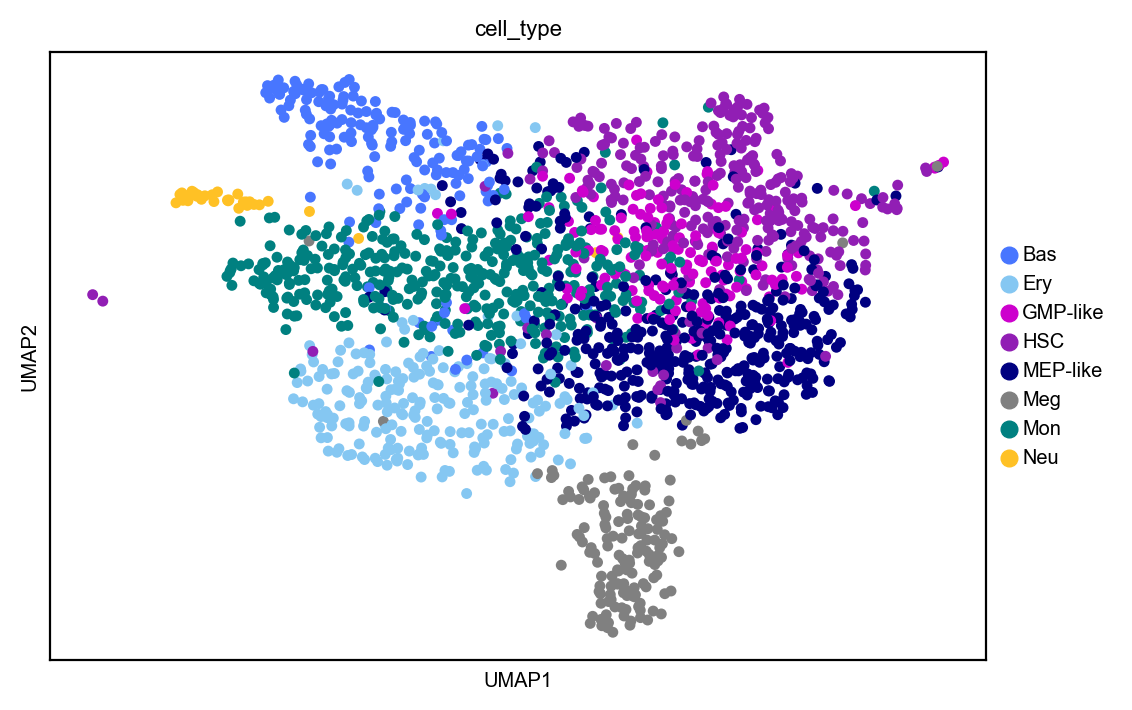

<IPython.core.display.Javascript object>

In [7]:
adata = _dynamo_pp(
    h5ad_path="/Users/mvinyard/hsc_all_combined_all_layers.h5ad",
    do_time_norm=True,
    use_key="labeled_TC",
)

sc.pp.recipe_seurat(adata)
adata, SCALER_MODEL, PCA_MODEL, UMAP_MODEL = _mev_dimension_reduction(adata)
adata = match_and_filter_on_idx(adata)
sc.pl.umap(adata, color=["cell_type"])

### Remove labeling time normalization step

AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch', 'nGenes', 'UMI', '_time', 't'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced', 'X_orig'


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


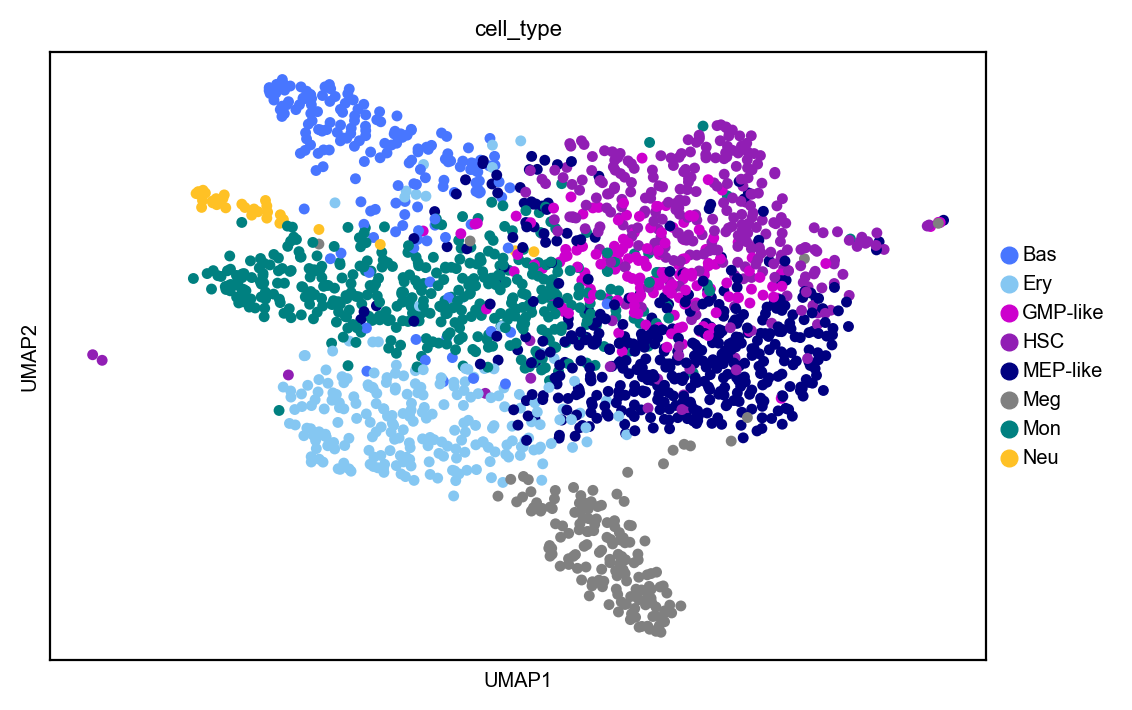

<IPython.core.display.Javascript object>

In [8]:
adata = _dynamo_pp(
    h5ad_path="/Users/mvinyard/hsc_all_combined_all_layers.h5ad",
    do_time_norm=False,
    use_key="labeled_TC",
)

sc.pp.recipe_seurat(adata)
adata, SCALER_MODEL, PCA_MODEL, UMAP_MODEL = _mev_dimension_reduction(adata)
adata = match_and_filter_on_idx(adata)
sc.pl.umap(adata, color=["cell_type"])

### Start from `adata.layers['total']`

AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch', 'nGenes', 'UMI', '_time', 't'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced', 'X_orig'


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad
|-----> in progress: 99.0945%|-----> [download] completed [56.7416s]


/Users/mvinyard/.anaconda3/envs/perturb/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


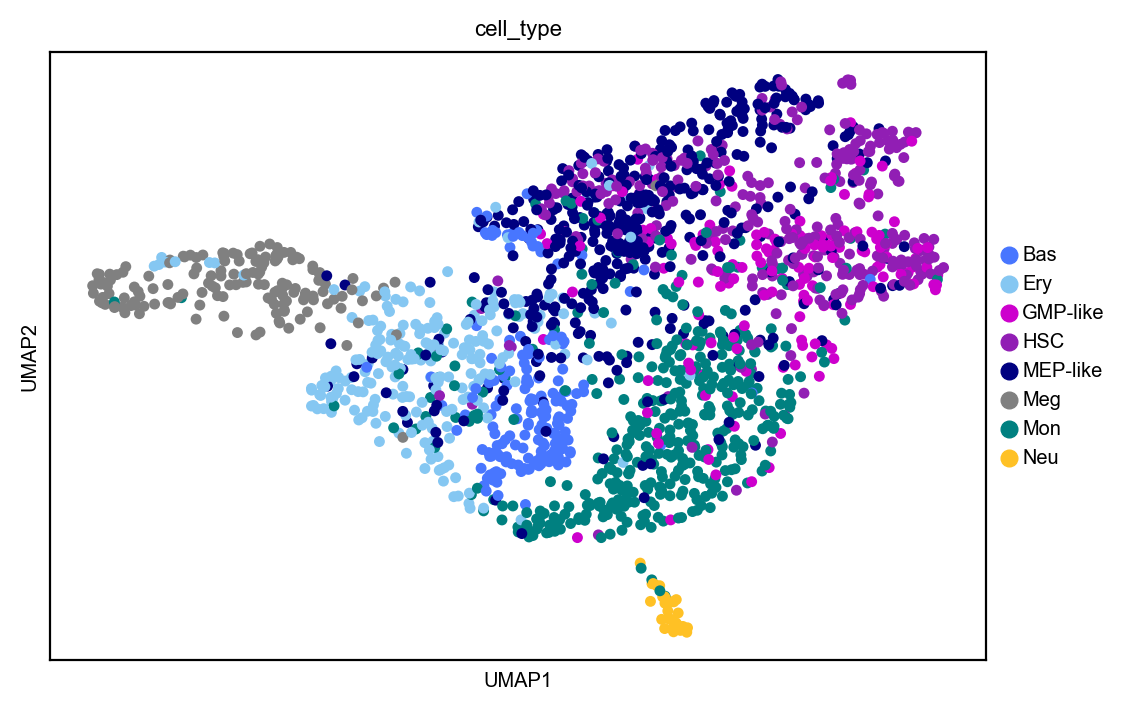

<IPython.core.display.Javascript object>

In [4]:
adata = _dynamo_pp(
    h5ad_path="/Users/mvinyard/hsc_all_combined_all_layers.h5ad",
    do_time_norm=True,
    use_key="total",
)

sc.pp.recipe_seurat(adata)
adata, SCALER_MODEL, PCA_MODEL, UMAP_MODEL = _mev_dimension_reduction(adata)
adata = match_and_filter_on_idx(adata)
sc.pl.umap(adata, color=["cell_type"])